In [3]:
#importing  necessary libaries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re
import itertools
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim
import pickle 
import pyLDAvis


     |████████████████████████████████| 1.6MB 6.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=ccb26a99ee51b48365e402db1ef905e939fa71142bf40da188b77ad0526a9232
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
data_url = 'https://raw.githubusercontent.com/deadex-ng/Task-2/main/cleaned_fintech_data.csv'

#read csv file,put it into a data frame
tweets_df = pd.read_csv(data_url)

In [5]:
#Get an idea of the data wea are working with
tweets_df.head(2)

,Unnamed: 0,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries,timestamp
0,0.0,Thu Jun 17 06:26:34 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Giving forth life is becoming a burden in Keny...,Giving forth life becoming burden Kenya This m...,"Sentiment(polarity=0.3194444444444445, subject...",0.3194444444444445,0.5305555555555556,en,0,0,reen_law,398,70,223,NaN,NaN,janetmachuka_,NaN,NaN,2021-06-17 06:26:34+00:00
1,1.0,Thu Jun 17 06:26:37 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Teenmaar - 26cr\nPanja - 32.5cr\nGabbarsingh -...,Teenmaar crPanja crGabbarsingh cr Khaleja Kuda...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,in,0,0,Amigo9999_,19047,132,1084,NaN,NaN,maheshblood,NaN,India,2021-06-17 06:26:37+00:00


In [6]:
#checking the datatypes 
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5621 entries, 0 to 5620
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              5620 non-null   float64
 1   created_at              5621 non-null   object 
 2   source                  5621 non-null   object 
 3   original_text           5621 non-null   object 
 4   clean_text              5617 non-null   object 
 5   sentiment               5621 non-null   object 
 6   polarity                5621 non-null   object 
 7   subjectivity            5621 non-null   object 
 8   lang                    5621 non-null   object 
 9   favorite_count          5621 non-null   object 
 10  retweet_count           5621 non-null   object 
 11  original_author         5621 non-null   object 
 12  screen_count            5621 non-null   object 
 13  followers_count         5621 non-null   object 
 14  friends_count           5621 non-null   

In [7]:
#Checking if data has null values 
#tweets_df.isnull()

In [8]:
#print all rows with Nan
new_df = tweets_df[ tweets_df.isna().any(axis=1)]

In [9]:
#Create a data frame with columns
tweets_df_one = pd.DataFrame(columns = ['original_text','clean_text','lang'])

#fill new data frame columns with data from tweets_df
tweets_df_one ['original_text'] = tweets_df['original_text'].to_list()
tweets_df_one ['clean_text'] = tweets_df['clean_text'].to_list()
tweets_df_one ['lang'] = tweets_df['lang'].to_list()

In [10]:
#remove rows with null values 
tweets_df_one.dropna()

,original_text,clean_text,lang
0,Giving forth life is becoming a burden in Keny...,Giving forth life becoming burden Kenya This m...,en
1,Teenmaar - 26cr\nPanja - 32.5cr\nGabbarsingh -...,Teenmaar crPanja crGabbarsingh cr Khaleja Kuda...,in
2,Rei chintu 2013 lo Vachina Ad Nizam ne 2018 lo...,Rei chintu lo Vachina Ad Nizam ne lo kottaru f...,hi
3,Today is World Day to Combat #Desertification ...,Today World Day Combat Restoring degraded land...,en
4,Hearing #GregHunt say he's confident vaccines ...,Hearing say 's confident vaccines delivered li...,en
...,...,...,...
5616,"Lambie has voted AGAINST Medivac, Carbon tax, ...",Lambie voted AGAINST Medivac Carbon tax protec...,en
5617,Idhi me bathuku \nMost Day1 Records In Nizam f...,Idhi bathuku Most Day1 Records In Nizam Non BB...,in
5618,welkin moon giveaway bc i finally have money!\...,welkin moon giveaway bc finally money -u got t...,en
5619,Manam edi chesina \n\nDaaniki kuda elevation i...,Manam edi chesina Daaniki kuda elevation istad...,et


In [13]:
#reseting  the index after dropping some rows
tweets_df_one.reset_index()

,index,original_text,clean_text,lang
0,0,Giving forth life is becoming a burden in Keny...,Giving forth life becoming burden Kenya This m...,en
1,1,Teenmaar - 26cr\nPanja - 32.5cr\nGabbarsingh -...,Teenmaar crPanja crGabbarsingh cr Khaleja Kuda...,in
2,2,Rei chintu 2013 lo Vachina Ad Nizam ne 2018 lo...,Rei chintu lo Vachina Ad Nizam ne lo kottaru f...,hi
3,3,Today is World Day to Combat #Desertification ...,Today World Day Combat Restoring degraded land...,en
4,4,Hearing #GregHunt say he's confident vaccines ...,Hearing say 's confident vaccines delivered li...,en
...,...,...,...,...
5616,5616,"Lambie has voted AGAINST Medivac, Carbon tax, ...",Lambie voted AGAINST Medivac Carbon tax protec...,en
5617,5617,Idhi me bathuku \nMost Day1 Records In Nizam f...,Idhi bathuku Most Day1 Records In Nizam Non BB...,in
5618,5618,welkin moon giveaway bc i finally have money!\...,welkin moon giveaway bc finally money -u got t...,en
5619,5619,Manam edi chesina \n\nDaaniki kuda elevation i...,Manam edi chesina Daaniki kuda elevation istad...,et


In [14]:
#create a function to find hashtags in tweets
#find everything that begins with '#' 
def find_hashtags(tweet):
  
  return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)',tweet)
  

In [15]:
#pass the tweet to 'find_hashtags' function and create a column 'hashtag'
tweets_df_one['hashtags'] = tweets_df_one.original_text.apply(find_hashtags)
print(tweets_df_one['hashtags'])

0                                                      []
1                                                      []
2                                                      []
3       [#Desertification, #Drought, #resilience, #bio...
4                         [#GregHunt, #Morrison, #auspol]
                              ...                        
5616                                             [#QandA]
5617                                                   []
5618                                                   []
5619                                                   []
5620                                                   []
Name: hashtags, Length: 5621, dtype: object


In [16]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = tweets_df_one.loc[
                       tweets_df_one.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [17]:
hashtags_list_df

,hashtags
3,"[#Desertification, #Drought, #resilience, #bio..."
4,"[#GregHunt, #Morrison, #auspol]"
5,"[#HowRutoSabotagedUhuru, #JKLive, #javascript,..."
6,"[#Desertification, #Drought, #resilience, #bio..."
9,[#microgrids]
...,...
5611,[#QandA]
5613,"[#npcindia, #webinar, #wastemgmt, #carboncredi..."
5614,"[#mobilemoney, #Burundi, #youth, #innovation]"
5615,"[#CarbonSmart, #OurCleanFuture]"


In [18]:
#create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [19]:
flattened_hashtags_df

,hashtag
0,#Desertification
1,#Drought
2,#resilience
3,#biodiversity
4,#climatechange
...,...
4245,#youth
4246,#innovation
4247,#CarbonSmart
4248,#OurCleanFuture


In [20]:
#add flatten_hashtags to tweet_df
tweets_df_one["flattened_hashtags"]= flattened_hashtags_df

#check the data frame 
tweets_df_one.head(3)

,original_text,clean_text,lang,hashtags,flattened_hashtags
0,Giving forth life is becoming a burden in Keny...,Giving forth life becoming burden Kenya This m...,en,[],#Desertification
1,Teenmaar - 26cr\nPanja - 32.5cr\nGabbarsingh -...,Teenmaar crPanja crGabbarsingh cr Khaleja Kuda...,in,[],#Drought
2,Rei chintu 2013 lo Vachina Ad Nizam ne 2018 lo...,Rei chintu lo Vachina Ad Nizam ne lo kottaru f...,hi,[],#resilience


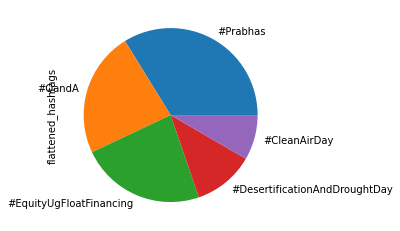

In [21]:
# To plot Top 5 Hashtags in pie chart
tweets_df_one['flattened_hashtags'].value_counts()[:5].plot(kind='pie')


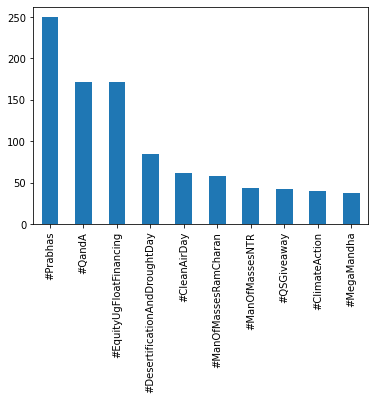

In [22]:
# To plot Top 10 Hashtags in bar graph
tweets_df_one['flattened_hashtags'].value_counts()[:10].plot(kind='bar')


In [23]:
#ploting Tweets by language 
tweets = pd.DataFrame(columns=['text','lang'])

tweets['text'] =  tweets_df_one['clean_text'].to_list()
tweets['lang'] = tweets_df_one['lang'].to_list()

tweets_by_lang = tweets['lang'].value_counts()

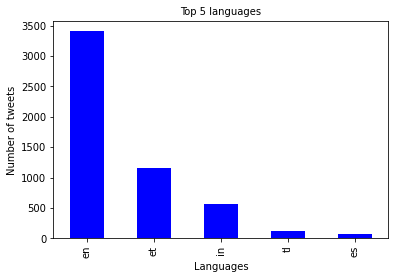

In [24]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=10)
ax.set_ylabel('Number of tweets' , fontsize=10)
ax.set_title('Top 5 languages', fontsize=10)
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='blue')

In [25]:
#from Our Language analysis we can see there are differnt languages we can select only tweets with english 
English_tweets = tweets_df_one.loc[tweets_df['lang'] =="en"]

#from Our Language analysis we can see there are differnt languages we can select only tweets with the Estonian language 
Estonian_tweets = tweets_df_one.loc[tweets_df['lang'] =="et"]

#Estonian_tweets

In [26]:
#text Preprocessing

#Turn all cleen_text to string
English_tweets['clean_text']=English_tweets['clean_text'].astype(str)

#all the clean_text should be in lower case
English_tweets['clean_text'] = English_tweets['clean_text'].apply(lambda x: x.lower())

#remove punctuation from clean_text
English_tweets['clean_text']= English_tweets['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))


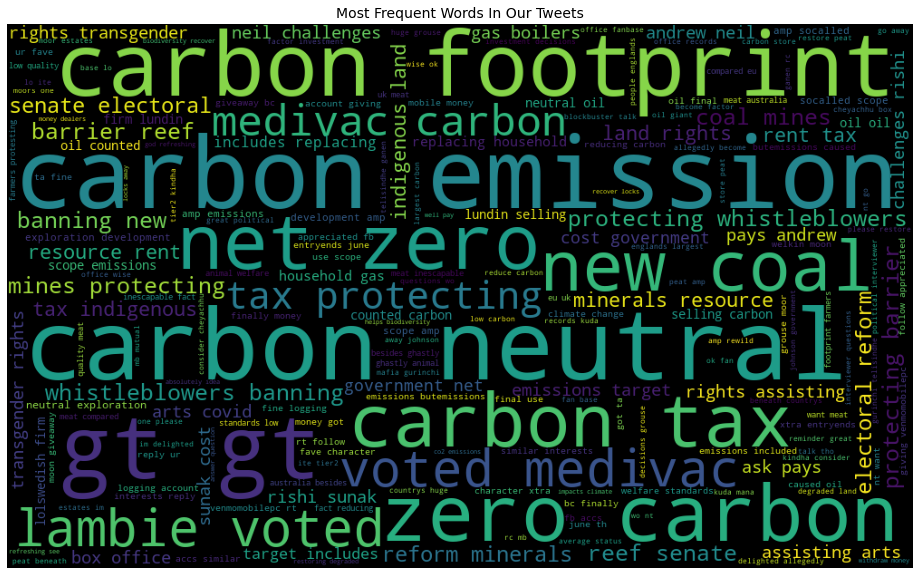

In [27]:
#ploting a word cloud with the most frequent words in the tweets 
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(English_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=14)
plt.show()

In [28]:
#Converting tweets to list of words For feature engineering
sentence_list = [tweet for tweet in English_tweets['clean_text']]
word_list = [sent.split() for sent in sentence_list]

word_list[:2]


[['giving',
  'forth',
  'life',
  'becoming',
  'burden',
  'kenya',
  'this',
  'mother',
  'gave',
  'birth',
  'babies',
  'hard',
  'time',
  'meeting',
  'nutritional',
  'needs',
  'coz',
  'baby',
  'formula',
  'expensiveturn',
  'bundles',
  'tears',
  'joy',
  'giving',
  'handmpesa',
  'douglas',
  'nyaoko'],
 ['today',
  'world',
  'day',
  'combat',
  'restoring',
  'degraded',
  'land',
  'brings',
  'jobs',
  'food',
  'security',
  'helps',
  'recover',
  'slows',
  'locking',
  'away',
  'carbon',
  'all',
  'critical',
  'lifting',
  'many',
  'poverty']]

In [29]:

#remove lists inside the list
flat_word_list = itertools.chain(*word_list)
flat_word_list = list(flat_word_list)

#tokenize flat_word_list
word_list_tokenized = [simple_preprocess(word) for word in flat_word_list]

In [30]:
nltk.download('stopwords')
#removing stopwords
word_list_tokenized_noSW = [word for word in word_list_tokenized if not word in stopwords.words()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:

#create a dictionary 
word_to_id = corpora.Dictionary(word_list_tokenized_noSW)

# Create Corpus
texts = word_list_tokenized_noSW

# Term Document Frequency
corpus = [word_to_id.doc2bow(text) for text in texts]

# View
#print(corpus)

In [32]:


# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word = word_to_id,
                                       num_topics=num_topics,
                                       random_state = 100, 
                                       chunksize =  50,
                                       passes = 17)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.149*"carbon" + 0.039*"oil" + 0.035*"government" + 0.018*"zero" + '
  '0.016*"scope" + 0.016*"gas" + 0.015*"idea" + 0.014*"per" + 0.013*"cost" + '
  '0.012*"pays"'),
 (1,
  '0.062*"emissions" + 0.054*"tax" + 0.041*"amp" + 0.029*"covid" + 0.022*"co" '
  '+ 0.019*"neutral" + 0.018*"johnson" + 0.017*"that" + 0.014*"increases" + '
  '0.014*"income"'),
 (2,
  '0.038*"the" + 0.031*"land" + 0.028*"nt" + 0.026*"electoral" + 0.020*"away" '
  '+ 0.018*"reminder" + 0.018*"wo" + 0.018*"political" + 0.017*"account" + '
  '0.017*"global"'),
 (3,
  '0.035*"money" + 0.034*"new" + 0.025*"voted" + 0.019*"one" + 0.019*"go" + '
  '0.018*"questions" + 0.017*"interviewer" + 0.014*"green" + '
  '0.014*"consumption" + 0.014*"most"'),
 (4,
  '0.040*"rights" + 0.039*"protecting" + 0.023*"coal" + 0.020*"footprint" + '
  '0.020*"arts" + 0.020*"assisting" + 0.020*"transgender" + 0.020*"indigenous" '
  '+ 0.020*"reform" + 0.020*"resource"')]


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, word_to_id)
pyLDAvis.display(LDAvis_prepared)
pyLDAvis.save_html(LDAvis_prepared,'lda.html')

In [ ]:


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list_tokenized_noSW, dictionary=word_to_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.8210197247844321
